In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

In [3]:
# Load the data

Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


In [4]:
# We can also impute the missing values of "horsepower" as we did previously

Auto['horsepower'].replace('?','104',inplace=True)
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'])

C:\Users\1yjac\AppData\Local\Temp\ipykernel_15128\20472145.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Auto['horsepower'].replace('?','104',inplace=True)


In [5]:
# We will use the numeric variables in the data to predict mpg

X = Auto[['cylinders','displacement','horsepower','weight','acceleration','year','origin']]
y = Auto['mpg']

In [6]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

X_train

,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,
hi 1200d,8,304.0,193,4732,18.5,70,1
chevrolet chevelle malibu classic,6,250.0,100,3781,17.0,74,1
volkswagen type 3,4,97.0,54,2254,23.5,72,2
buick opel isuzu deluxe,4,111.0,80,2155,14.8,77,1
amc concord,6,232.0,90,3210,17.2,78,1
...,...,...,...,...,...,...,...
ford country squire (sw),8,400.0,170,4746,12.0,71,1
subaru,4,97.0,67,2065,17.8,81,3
volkswagen rabbit,4,97.0,71,1825,12.2,76,2


## Gradient Boosting

### An Initial Model

In [7]:
# Build the model
# Documentation: https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

gbm_auto = GBR(learning_rate=0.5,
               n_estimators=50,
               max_depth=5,
               random_state=314)
gbm_auto.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=5, n_estimators=50,
                          random_state=314)

In [8]:
# Calculate MSE on test set

# Get predictions on test
y_hat_gbm = gbm_auto.predict(X_test)

# Calculate MSE
mse_gbm = np.mean((y_test - y_hat_gbm)**2)
print('test mse: ',mse_gbm)

test mse:  5.908193240674852


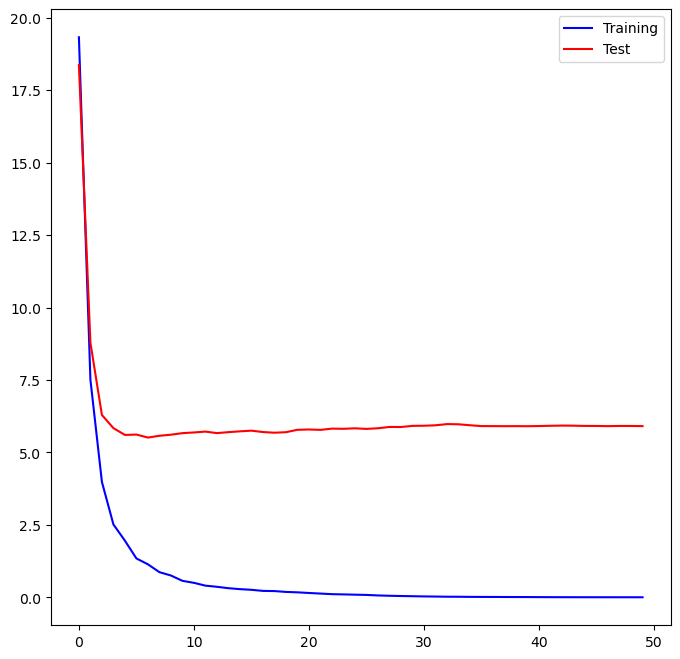

In [9]:
# We can actually plot the "progress" of a GBM

test_error = np.zeros_like(gbm_auto.train_score_)
for idx, y_ in enumerate(gbm_auto.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(gbm_auto.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        gbm_auto.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

### Feature Importance

Note that a feature importance list from a RF model is generally more robust than one from a GBM, but this is still helpful for explainability purposes.

In [10]:
# Feature importance list
feature_names = list(X_train.columns)
feature_imp = pd.DataFrame(
    {'importance':gbm_auto.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
displacement,0.630639
horsepower,0.125323
year,0.123788
weight,0.076146
acceleration,0.033457
origin,0.006017
cylinders,0.004630


## Single Lift Chart

In [11]:
# Create a lift chart to assess a single model (thank you ChatGPT)

def plot_regression_lift_chart(y_true, y_preds, n_bins=10):
    """
    Plots a lift chart for a regression model.

    Parameters:
    - y_true: Array-like of true continuous values.
    - y_preds: Array-like of predicted values.
    - n_bins: Number of bins to use for the lift chart.
    """
    # Create a DataFrame with true values and predicted values
    data = pd.DataFrame({'y_true': y_true, 'y_preds': y_preds})
    
    # Sort the DataFrame by predicted values
    data = data.sort_values(by='y_preds', ascending=False)

    # Create bins based on predicted values
    data['bin'] = pd.qcut(data['y_preds'], n_bins, labels=False)

    # Calculate lift
    lift_data = data.groupby('bin').agg(
        total_count=('y_true', 'count'),
        actual_mean=('y_true', 'mean'),
        predicted_mean=('y_preds', 'mean')
    ).reset_index()

    # Calculate expected mean (mean of actual values)
    expected_mean = data['y_true'].mean()
    
    # Calculate lift
    lift_data['lift'] = lift_data['actual_mean'] / expected_mean

    # Plot the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(lift_data['bin'], lift_data['lift'], marker='o', label='Lift')
    plt.axhline(y=1, color='r', linestyle='--', label='Random Guessing Lift (1)')
    plt.title('Lift Chart for Regression Model')
    plt.xlabel('Bins')
    plt.ylabel('Lift')
    plt.xticks(lift_data['bin'])
    plt.legend()
    plt.grid()
    plt.show()

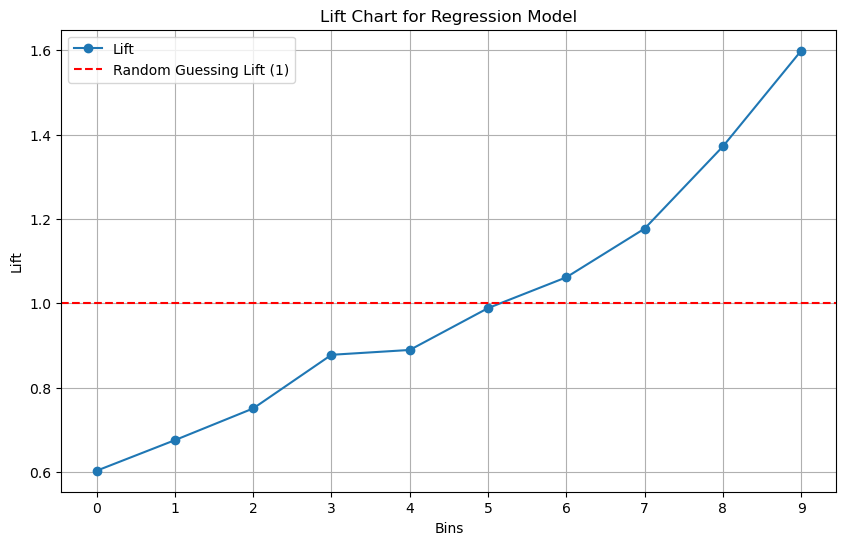

In [12]:
plot_regression_lift_chart(y_test, y_hat_gbm, n_bins=10)

### A Better Model

In [13]:
# Let's build a better model

gbm_auto_baseline = GBR(learning_rate=0.01,
                        n_estimators=500,
                        max_depth=5,
                        random_state=314)
gbm_auto_baseline.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=314)

In [14]:
# Calculate MSE on test set

# Get predictions on test
y_hat_gbm_baseline = gbm_auto_baseline.predict(X_test)

# Calculate MSE
mse_gbm_baseline = np.mean((y_test - y_hat_gbm_baseline)**2)
print('test mse: ',mse_gbm_baseline)
print('previous test mse: ',mse_gbm)

test mse:  4.806520354928368
previous test mse:  5.908193240674852


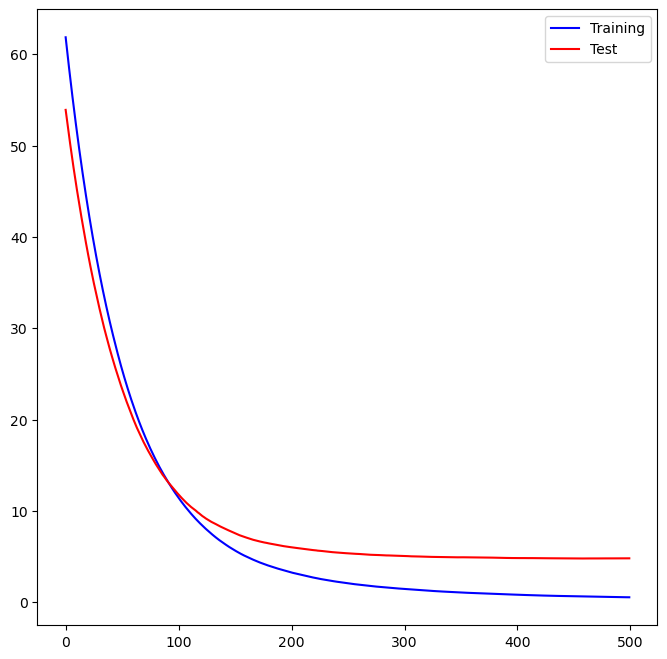

In [15]:
# What does the "progress" look like?

test_error = np.zeros_like(gbm_auto_baseline.train_score_)
for idx, y_ in enumerate(gbm_auto_baseline.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(gbm_auto_baseline.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        gbm_auto_baseline.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

## Double Lift Chart

In [16]:
# Create a double lift chart to compare two models
## Note that this needed a LOT of prompt engineering in ChatGPT, and still needed manual edits.

def plot_double_lift_chart(y_true, y_pred_model1, y_pred_model2,
                           model1_name='Model A', model2_name='Model B',
                           n_bins=10):
    """
    Plots a double lift chart comparing two regression models, 
    where bins are sorted by the ratio of Model 1 to Model 2 predictions.

    Parameters:
    - y_true: Array-like of true continuous values.
    - y_pred_model1: Array-like of predicted values from Model 1.
    - y_pred_model2: Array-like of predicted values from Model 2.
    - model1_name, model2_name: Names to display in the legend.
    - n_bins: Number of quantile bins to use for the lift chart.
    """

    # Build combined dataframe
    data = pd.DataFrame({
        'y_true': y_true,
        'pred1': y_pred_model1,
        'pred2': y_pred_model2
    })

    # Avoid division by zero
    data = data[data['pred2'] != 0]

    # Compute ratio of predictions
    data['ratio'] = data['pred1'] / data['pred2']

    # Sort descending by ratio
    data = data.sort_values(by='ratio', ascending=False)

    # Create quantile bins based on the ratio
    data['bin'] = pd.qcut(data['ratio'], n_bins, labels=False, duplicates='drop')

    # Overall means for normalization
    overall_mean_true = data['y_true'].mean()
    overall_mean_pred1 = data['pred1'].mean()
    overall_mean_pred2 = data['pred2'].mean()

    # Aggregate lift stats for each bin
    lift_data = data.groupby('bin').agg(
        actual_mean=('y_true', 'mean'),
        model1_mean=('pred1', 'mean'),
        model2_mean=('pred2', 'mean')
    ).reset_index()

    # Compute model error in each bin
    lift_data['model1_lift'] = lift_data['model1_mean'] / lift_data['actual_mean']
    lift_data['model2_lift'] = lift_data['model2_mean'] / lift_data['actual_mean']

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(lift_data['bin'], lift_data['model1_lift'], marker='s', linestyle='-', linewidth=2, label=f'{model1_name} Predicted Lift')
    plt.plot(lift_data['bin'], lift_data['model2_lift'], marker='^', linestyle='--', linewidth=2, label=f'{model2_name} Predicted Lift')

    plt.axhline(y=1, color='red', linestyle=':', label='Baseline (Lift = 1)')
    plt.title(f'Double Lift Chart by Ratio of {model1_name} / {model2_name}', fontsize=14)
    plt.xlabel(f'Bins (sorted by {model1_name} / {model2_name} ratio)')
    plt.ylabel('Lift (Mean / Overall Mean)')
    plt.xticks(np.arange(0, lift_data.shape[0]))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

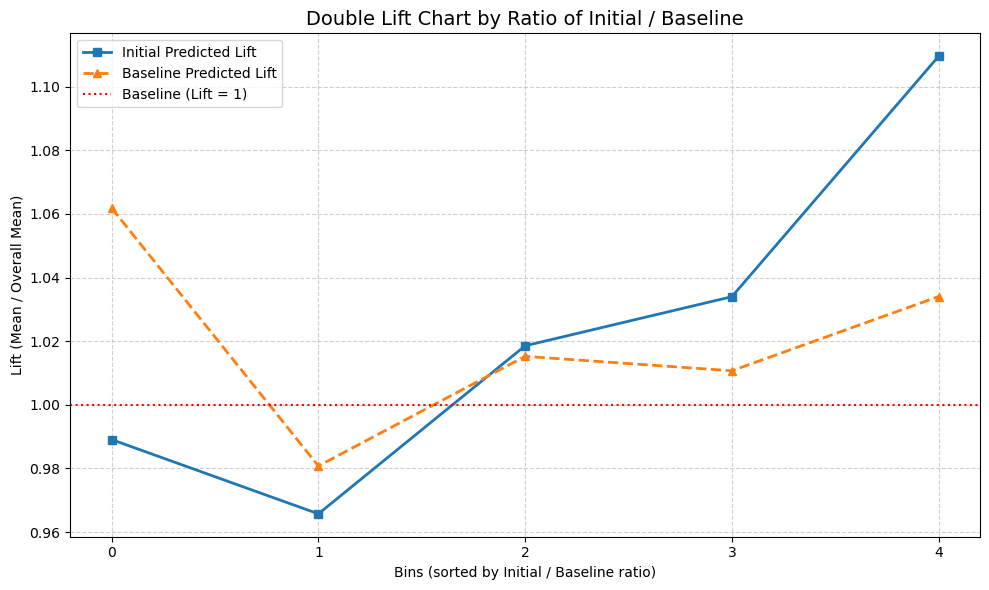

In [17]:
plot_double_lift_chart(y_test, y_hat_gbm, y_hat_gbm_baseline,
                           model1_name='Initial', model2_name='Baseline',
                           n_bins=5)